# Decision Trees and Random Forests

**In this Lecture we will be going over Decision Trees and Random Forests. In order for you to understand this lecture completely there is some required reading. First read my blog post [here](https://medium.com/@josemarcialportilla/enchanted-random-forest-b08d418cb411)**


After reading the blog post you should have a basic layman's (or laywoman!) understanding of how decision trees and random forests work. Lets see how we can implement them in Python!

In [36]:
#Imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

## Random Forest Classifier

Random forests are a classic example of an ensemble learner. As described in the blog posts random forests are an ensemble of many weak learners (decision trees).

Let's start by discussing Decision Trees themselves.

### Creating Decision Trees

We know from the blog posts that [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree) utilize binary splitting to make decisions based on features (the questions we asked). So lets go ahead and create some data using some built-in functions in SciKit-Learn:

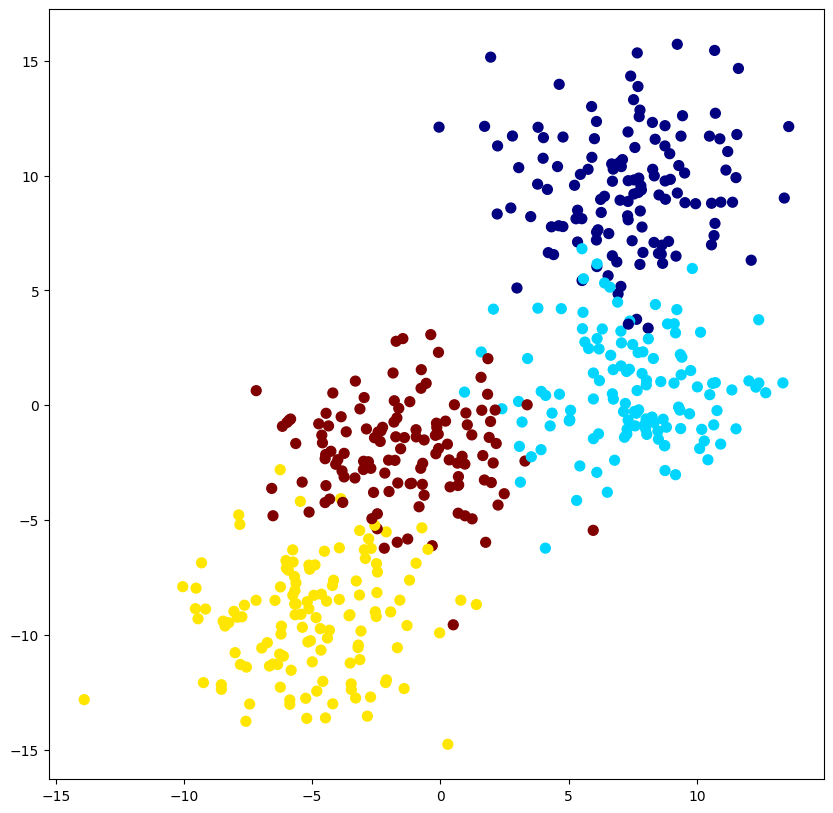

In [37]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=500, centers=4,
                  random_state=8, cluster_std=2.4)

#Scatter plot the points
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')

In [38]:
from sklearn.tree import DecisionTreeClassifier

Before we begin implementing the Decision Tree, lets create a nice function to plot out the decision boundaries using [mesh grid](http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) (a technique common to the Sci-Kit Learn documentation).

### Visualization Function

In [39]:
def visualize_tree(classifier, X, y, boundaries=True,xlim=None, ylim=None):
    '''
    Visualizes a Decision Tree.
    INPUTS: Classifier Model, X, y, optional x/y limits.
    OUTPUTS: Meshgrid visualization for boundaries of the Decision Tree
    '''

    # Fit the X and y data to the tree
    classifier.fit(X, y)


    # Automatically set the x and y limits to the data (+/- 0.1)
    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    # Assign the variables
    x_min, x_max = xlim
    y_min, y_max = ylim


    # Create a mesh grid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Define the Z by the predictions (this will color in the mesh grid)
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # Reshape based on meshgrid
    Z = Z.reshape(xx.shape)

    # Plot the figure (use)
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='jet')


    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')

    #Set Limits
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    def plot_boundaries(i, xlim, ylim):
        '''
        Plots the Decision Boundaries
        '''
        if i < 0:
            return

        # Shorter variable name
        tree = classifier.tree_

        # Recursively go through nodes of tree to plot boundaries.
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)

        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])

    # Random Forest vs Single Tree
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

**Let's plot out a Decision Tree boundary with a max depth of two branches**

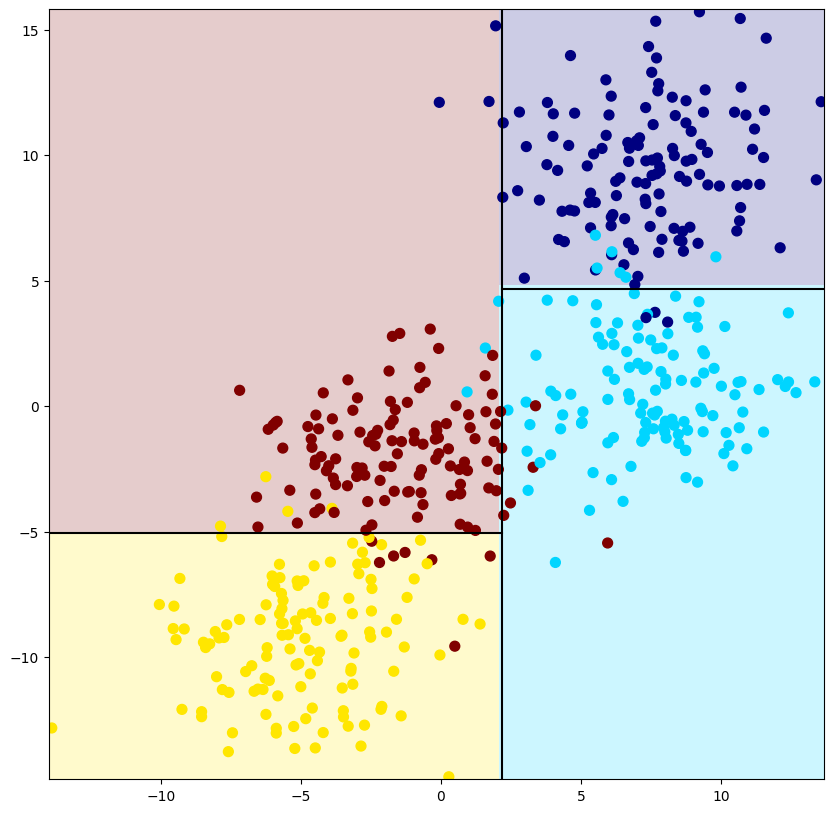

In [40]:
# Set model variable
clf = DecisionTreeClassifier(max_depth=2,random_state=0)

# Show Boundaries
visualize_tree(clf,X,y)

**How about 4 levels deep?**

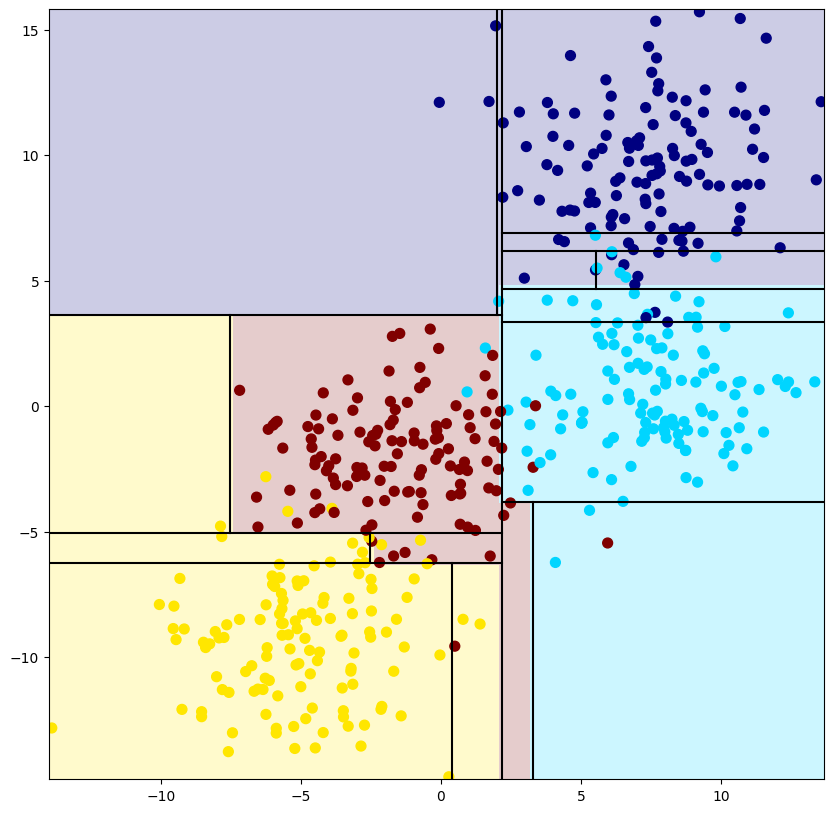

In [41]:
# Set model variable
clf = DecisionTreeClassifier(max_depth=4,random_state=0)

# Show Boundaries
visualize_tree(clf,X,y)

Notice how changing the depth of the decision causes the boundaries to change substantially! If we pay close attention to the second model we can begin to see evidence of **[over-fitting](http://www.saedsayad.com/decision_tree_overfitting.htm)**. This basically means that if we were to try to predict a new point the result would be influenced more by the noise than the signal.

So how do we address this issue? The answer is by creating an *ensemble* of decision trees.

## Random Forests

Ensemble Methods essentially average the results of many individual estimators which over-fit the data. The resulting estimates are much more robust and accurate than the individual estimates which make them up! One of the most common ensemble methods is the Random Forest, in which the ensemble is made up of many decision trees which are in some way perturbed. Lets see how we can use Sci-Kit Learn to create a random forest (its actually very simple!)

Note that n_estimators stands for the numerb of trees to use. You would intuitively know that using more decision trees would be better, but after a certain amount of trees (somewhere between 100-400 depending on your data) the benefits in accuracy of adding more estimators significantly decreases and just becomes a load on your CPU.

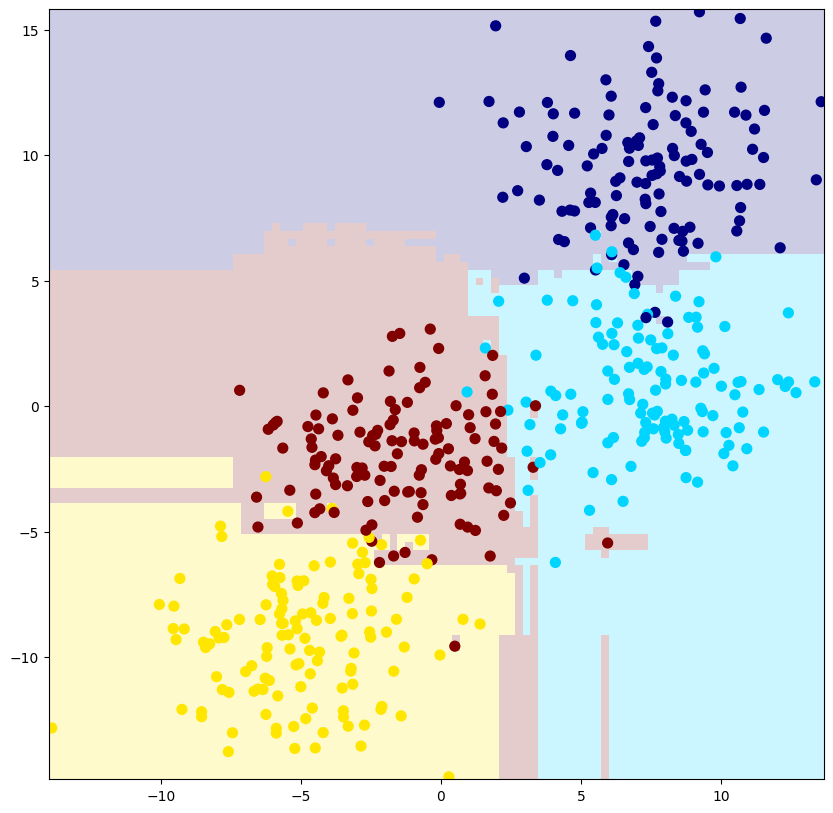

In [42]:
from sklearn.ensemble import RandomForestClassifier

# n_estimators
clf = RandomForestClassifier(n_estimators=100,random_state=0)

# Get rid of boundaries to avoid error
visualize_tree(clf,X,y,boundaries=False)

You can see that the random forest has been able to pick up features that the Decision Tree was not able to (although we must be careful of over-fitting with Random Forests too!)

While a visual is nice, a better way to evaluate our model would be with train test split if we had real data!

## Random Forest Regression
We can also use Random Forests for Regression! Let's see a quick example!

Let's imagine we have some sort of weather data thats sinusoidal in nature with some noise. It has a slow oscillation component, a fast oscillation component, and then a random noise component.

<ErrorbarContainer object of 3 artists>

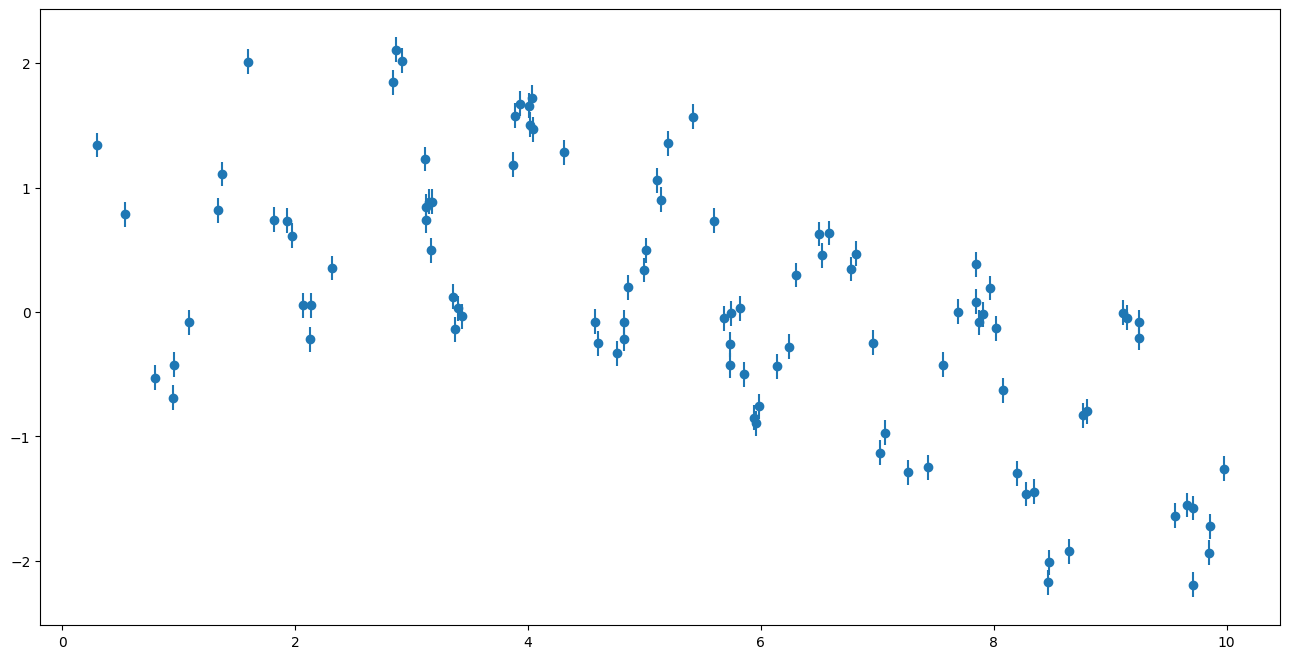

In [43]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)

def sin_model(x, sigma=0.2):
    '''
    Generate random sinusoidal data for regression analysis. Does SciKit-Learn have this?
    '''

    noise = sigma * np.random.randn(len(x))

    return np.sin(5 * x) + np.sin(0.5 * x) + noise

# Call y for data with x
y = sin_model(x)

# Plot x vs y
plt.figure(figsize=(16,8))
plt.errorbar(x, y, 0.1, fmt='o')

Now lets use a Random Forest Regressor to create a fitted regression, obviously a standard linear regression approach wouldn't work here. And if we didn't know anything about the true nature of the model, polynomial or sinusoidal regression would be tedious.

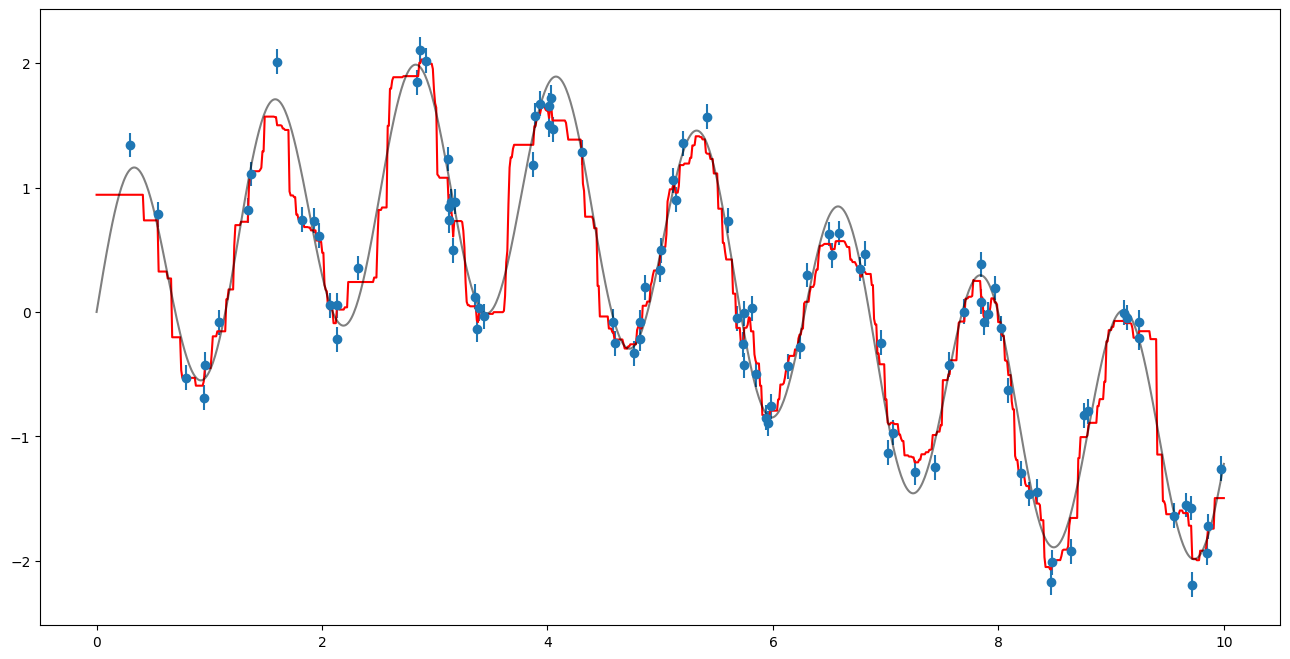

In [45]:
# X points for testing
xfit = np.linspace(0, 10, 1000)

# Model
rfr = RandomForestRegressor(100)

# Fit Model (Format array for y with [:,None])
rfr.fit(x[:, None], y) # i.e. it converts array of N elements into array of arrays with N elements


# Set predicted points
yfit = rfr.predict(xfit[:, None])

# Set real poitns (the model function)
ytrue = sin_model(xfit, 0)

# Plot
plt.figure(figsize=(16,8))
plt.errorbar(x, y, 0.1, fmt='o')

plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

As you can see, the non-parametric [!](https://medium.com/analytics-vidhya/parametric-and-nonparametric-models-in-machine-learning-a9f63999e233) random forest model is flexible enough to fit the multi-period data, without us even specifying a multi-period model!

This is a tradeoff between simplicity and thinking about what your data actually is.

Here are some more resources for Random Forests:

[Extensive Article on Wikipedia](https://en.wikipedia.org/wiki/Random_forest)

[A whole webpage form the inventors themselves! Leo Breiman and Adele Cutler](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm)

Its strange to think Random Forests is actually trademarked!

# Great Job!